In [8]:
%pylab inline
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import daft
mpl.rc('text',usetex=True)

SEED = None
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


Let's explore BBVI for the following model. This model is actually fully
conjugate, so we can do exact posterior inference and compare the results.

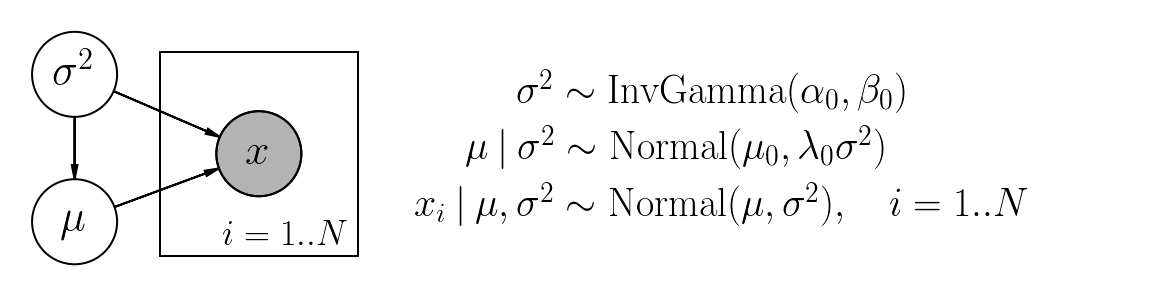

In [9]:
def draw_graphical_model():
  mpl.rcParams['font.size'] = 22

  def make_node(name, label, x, y, observed=False):
    return daft.Node(name, label, x, y,
                     scale=1.5, offset=(-.3, 1.), observed=observed)

  pgm = daft.PGM((10, 2.2))
  pgm.add_node(make_node('scale', r'$\sigma^2$', .5, 1.7))
  pgm.add_node(make_node('loc', r'$\mu$', .5, .4))
  pgm.add_node(make_node('x', r'$x$', 2.125, 1., observed=True))
  pgm.add_plate(daft.Plate(rect=(1.25, 0.1, 1.75, 1.8)))
  pgm.add_edge('scale', 'loc')
  pgm.add_edge('loc', 'x')
  pgm.add_edge('scale', 'x')
  pgm.render()
  # Plate label
  pgm._ctx._ax.text(3.6, .4, r"$i=1..N$", fontsize=18)
  # Adjacent text describing conditional distributions
  pgm._ctx._ax.text(8.8, 2.8, r"$\sigma^2 \sim \mathrm{InvGamma}(\alpha_0, \beta_0)$", fontsize=20)
  pgm._ctx._ax.text(7.9, 1.8, r"$\mu \:|\: \sigma^2 \sim \mathrm{Normal}(\mu_0, \lambda_0 \sigma^2)$", fontsize=20)
  pgm._ctx._ax.text(7, 0.8, r"$x_i \:|\: \mu, \sigma^2 \sim \mathrm{Normal}(\mu, \sigma^2), \quad i = 1..N$", fontsize=20)
  plt.show()
draw_graphical_model()

Given the generative model above, we can write down the factored joint distriubtion:

$$
p(\mu, \sigma^2, x_1, \ldots, x_N \:|\: \alpha_0, \beta_0, \mu_0, \lambda_0) =
     p(\sigma^2 \:|\: \alpha_0, \beta_0)
     \: p(\mu \:|\: \mu_0, \sigma^2, \lambda_0)
     \prod_{i = 1}^{N} p(x_i \:|\: \mu, \sigma^2)
$$

And the log-joint is just

$$
\log p(\mu, \sigma^2, x_1, \ldots, x_N \:|\: \alpha_0, \beta_0, \mu_0, \lambda_0) =
     \log p(\sigma^2 \:|\: \alpha_0, \beta_0)
     \log p(\mu \:|\: \mu_0, \sigma^2, \lambda_0)
     \sum_{i = 1}^{N} \log p(x_i \:|\: \mu, \sigma^2)
$$

Since this model is conjugate, the posterior is again a Normal-InverseGamma , with
parameters (see [this doc](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf)
for various derivations) 

$$
\begin{align}
\lambda_* &= \frac{1}{1/\lambda_0 + N} \\
\mu_* &= \lambda_* \left( \frac{\mu_0}{\lambda_0} + \sum_i x_i \right) \\
\alpha_* &= \alpha_0 + \frac{N}{2} \\
\beta_* &= \beta_0 + \frac{1}{2}\left( 
    \frac{\mu_0^2}{\lambda_0} - \frac{\mu_*^2}{\lambda_*} + \sum_i x_i^2
    \right)
\end{align}
$$

In [10]:
# A function which returns a callable that represents the generative process.
def make_generative_model(alpha_0, beta_0, lambda_0, mean_0):
  def generative_model(num_observations, num_prior_samples=1):
    variance_prior_rv = tfp.distributions.InverseGamma(alpha_0, beta_0)
    variance = variance_prior_rv.sample(num_prior_samples, seed=SEED)

    mean_prior_rv = tfp.distributions.Normal(mean_0,
                                             tf.sqrt(lambda_0 * variance))
    mean = mean_prior_rv.sample(seed=SEED)

    observation_rv = tfp.distributions.Normal(mean, tf.sqrt(variance))
    observations = observation_rv.sample(num_observations, seed=SEED)
    return (mean_prior_rv, mean,
            variance_prior_rv, variance,
            observation_rv, observations)
  return generative_model

In [11]:
# A function which returns a callable that represents the posterior model
def make_posterior_model(alpha_0, beta_0, lambda_0, mean_0):
  def posterior_model(observations, num_posterior_samples):
    num_observations = observations.shape[0].value

    lambda_post = 1. / (1. / lambda_0 + num_observations)
    mean_post = lambda_post * (mean_0 / lambda_0 + tf.reduce_sum(observations))

    alpha_post = alpha_0 + .5 * num_observations
    beta_post = beta_0 + .5 * (
        mean_0**2 / lambda_0 - mean_post**2 / lambda_post +
        tf.reduce_sum(observations**2))

    variance_post_rv = tfp.distributions.InverseGamma(alpha_post, beta_post)
    variance_post_sample = variance_post_rv.sample(num_posterior_samples, seed=SEED)

    mean_post_rv = tfp.distributions.Normal(
        mean_post, tf.sqrt(lambda_post * variance_post_sample))
    mean_post_sample = mean_post_rv.sample(seed=SEED)
    return mean_post_rv, mean_post_sample, variance_post_rv, variance_post_sample
  return posterior_model

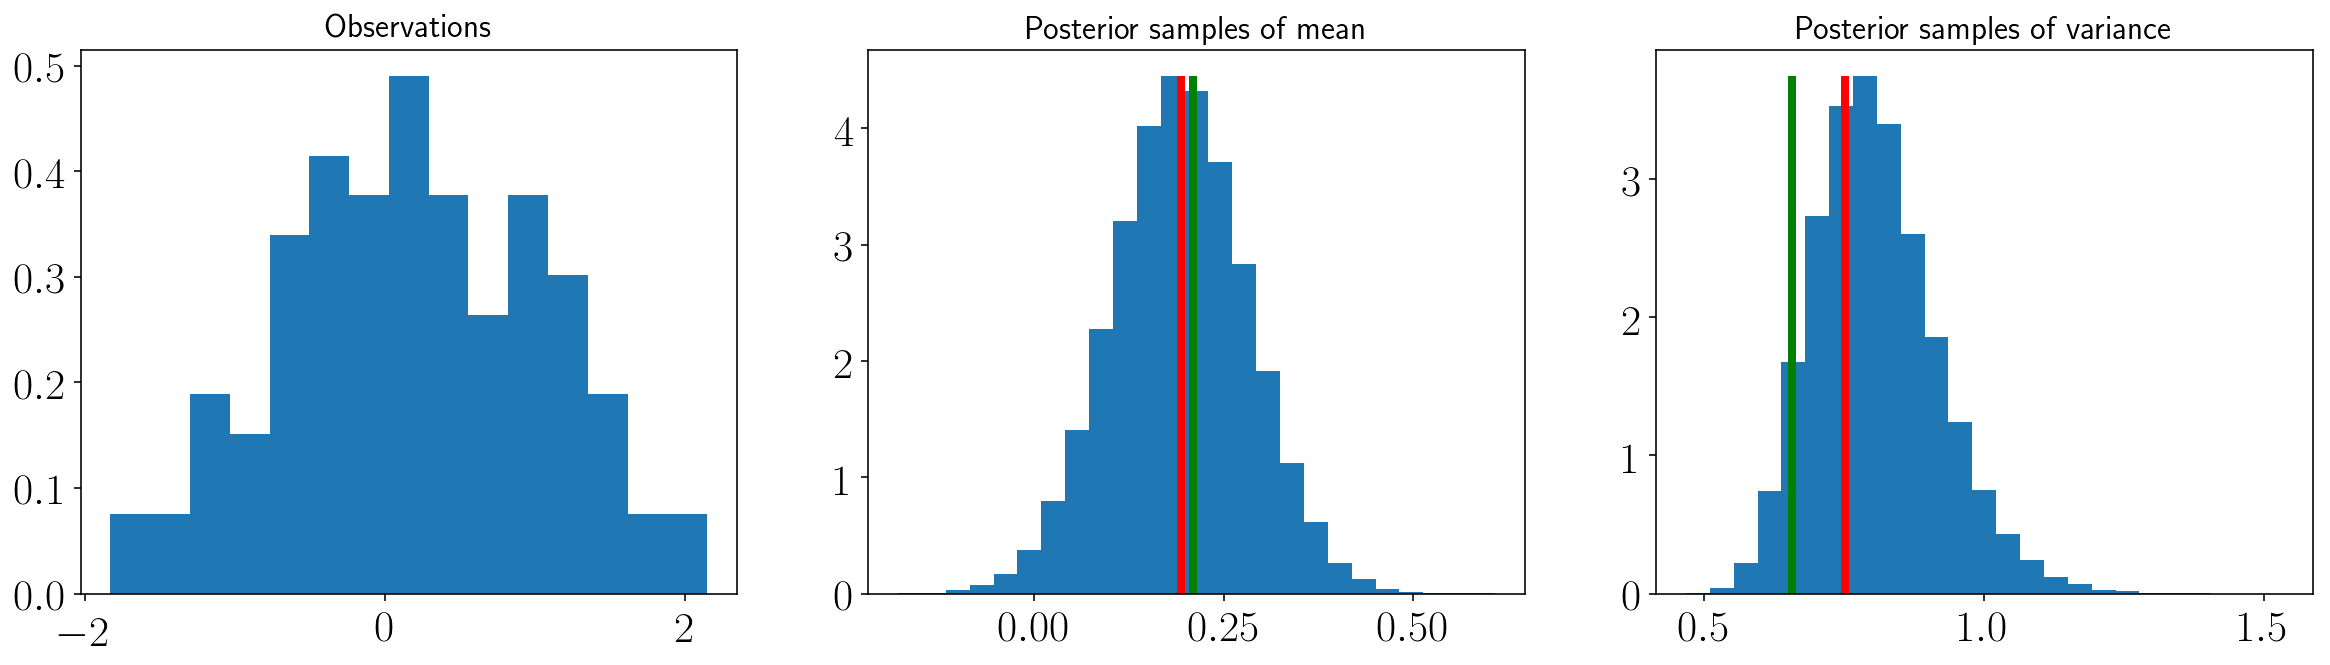

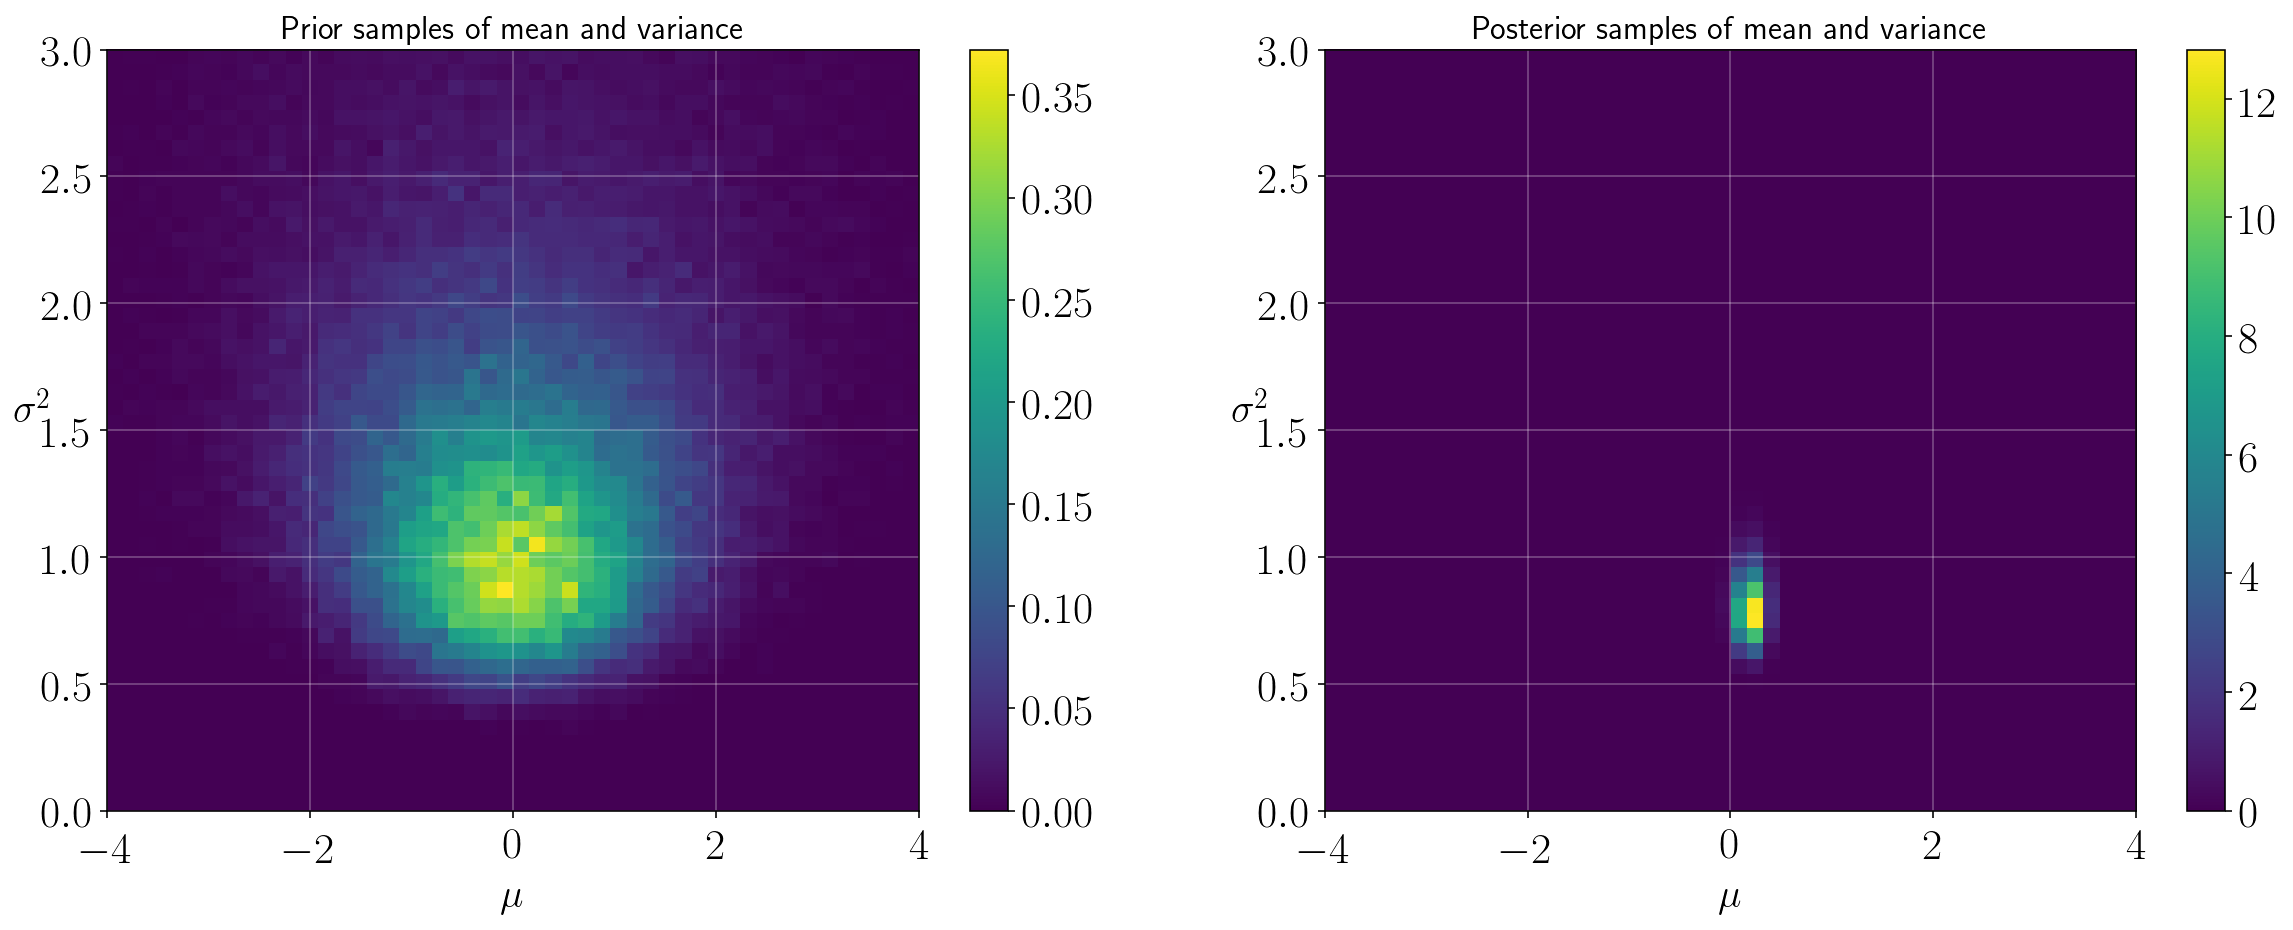

True mean/var: 0.209647, 0.656609
Sample mean/var: 0.193863, 0.750949
Mean posterior mean/var: 0.192077, 0.007998
Variance posterior mean/var: 0.807037, 0.012216


In [12]:
def _():
  tf.reset_default_graph()

  # Prior parameters for mu and sigma^2
  alpha_0 = 5.
  beta_0 = 6.
  lambda_0 = 1.
  mean_0 = 0.

  # Generative and posterior model callables
  generative_model = make_generative_model(alpha_0, beta_0, lambda_0, mean_0)
  posterior_model = make_posterior_model(alpha_0, beta_0, lambda_0, mean_0)

  # Generate a ton of mean/variance samples from the prior, for plotting later
  _, prior_mean_samples, _, prior_variance_samples, _, _ = generative_model(
      num_observations=0, num_prior_samples=100000)

  # Generate one true mean and variance, their corresponding RV's (Distribution
  # objects) the observation RV, and a handful of observations.
  num_observations = 100
  (prior_mean_rv,
   true_mean,
   prior_variance_rv,
   true_variance,
   observation_rv,
   observations) = generative_model(num_observations)

  # Construct posterior mean/variance RV's as well as a ton of samples.
  (posterior_mean_rv,
   posterior_mean_samples,
   posterior_variance_rv,
   posterior_variance_samples) = posterior_model(observations, 100000)

  # Run the graph, and collect the values of the Tensors created above 
  with tf.Session() as sess:
    (
        prior_mean_samples_, prior_variance_samples_,
        true_mean_, true_variance_, observations_,
        posterior_mean_samples_, posterior_variance_samples_,
    ) = sess.run([
        prior_mean_samples, prior_variance_samples,
        true_mean, true_variance, observations,
        posterior_mean_samples, posterior_variance_samples
    ])

  #
  # Draw lots of pretty pictures and print some stats
  #
  plt.figure(figsize=(20, 5))
  ax = plt.subplot(1, 3, 1)
  ax.hist(observations_, bins=15, density=True)
  ax.set_title("Observations", fontsize=16)

  ax = plt.subplot(1, 3, 2)
  freqs, _, _ = ax.hist(posterior_mean_samples_, bins=25, density=True)
  ax.vlines(true_mean_, 0, np.max(freqs), color='g', linewidth=4)
  ax.vlines(np.mean(observations_), 0, np.max(freqs), color='r', linewidth=4)
  ax.set_title("Posterior samples of mean", fontsize=16)

  ax = plt.subplot(1, 3, 3)
  freqs, _, _ = ax.hist(posterior_variance_samples_, bins=25, density=True)
  ax.vlines(true_variance_, 0, np.max(freqs), color='g', linewidth=4)
  ax.vlines(np.var(observations_), 0, np.max(freqs), color='r', linewidth=4)
  ax.set_title("Posterior samples of variance", fontsize=16)
  plt.show()

  
  plt.figure(figsize=(20, 7))
  plot_range = [[-4., 4.], [0, 3]]
  for i, (means, variances, dist_title) in enumerate(
      [(prior_mean_samples_, prior_variance_samples_, 'Prior'),
       (posterior_mean_samples_, posterior_variance_samples_, 'Posterior')]):
    ax = plt.subplot(1, 2, i + 1)
    _, _, _, colors = ax.hist2d(means, variances, bins=50,
                                range=plot_range, normed=True)
    ax.set_xlim(*plot_range[0])
    ax.set_ylim(*plot_range[1])
    ax.grid(color='white', alpha=.3)
    ax.set_title('%s samples of mean and variance' % dist_title, fontsize=16)
    ax.set_xlabel(r'$\mu$', fontsize=20)
    ax.set_ylabel(r'$\sigma^2$', fontsize=20, rotation='horizontal')
    plt.colorbar(colors, ax=ax)
  plt.show()

  print("True mean/var: %f, %f" % (true_mean_, true_variance_))
  print("Sample mean/var: %f, %f" % (np.mean(observations_),
                                     np.var(observations_)))
  print("Mean posterior mean/var: %f, %f" % (np.mean(posterior_mean_samples_),
                                             np.var(posterior_mean_samples_)))
  print("Variance posterior mean/var: %f, %f" % (np.mean(posterior_variance_samples_),
                                                 np.var(posterior_variance_samples_)))

_()

For our variational approximation, we'll assume a fully factorized distribution over $\mu$ and $\sigma^2$:

$$
q(\mu, \sigma^2) = q(\mu) \: q(\sigma^2).
$$

In particular, we'll use a Normal distribution for $q(\mu)$ and an InverseGamma
for $q(\sigma^2)$. Note that this is in fact different from the structure of our
conjugate posterior above, whereing $\mu$ has a conditional dependence on
$\sigma^2$ mediated by the $\lambda$ parameter. We need distinct
parameters for these variational $q$ distributions. We'll write

$$
q(\mu) = \mathrm{Normal}\left(\mu \:|\: \hat{\mu}, \hat{\sigma}^2\right) \\
q(\sigma^2) =
    \mathrm{InvGamma}\left(\sigma^2 \:|\: \hat\alpha, \hat\beta\right).
$$

We'll seek to optimize these four variational parameters, so as to minimize the
$\mathrm{KL}$ divergence between $q(\mu, \sigma^2)$ and the true posterior.
This leads to the so-called *evidence lower bound*, or $\mathrm{ELBO}$.

$$
\mathrm{KL}\left(
    q\left(\mu, \sigma^2\right) ||
    \: p\left(\mu, \sigma^2 \:|\: \{x_i\}_{i=1}^N\right)
\right) = \mathbb{E}_{q}\left[
    \log \frac{q\left(\mu, \sigma^2\right)}{
                      p\left(\mu, \sigma^2 \:|\: \{x_i\}_{i=1}^N\right)}
\right]
$$

$$
\mathrm{ELBO} = \mathbb{E}_q\left[\log p\left(\mu, \sigma^2, \{x_i\}\right)\right] + \mathbb{H}[q]
$$

where $\mathbb{H}[q]$ is the entropy of the $q$. One straightforward way to
optimize the $\mathrm{ELBO}$ is via gradient descent. Letting $\phi$ refer
generically to the vector of variational parameters, we'd like to perform updates

$$
\phi_{t+1} \leftarrow \phi_t + \rho_t \nabla_\phi \mathbb{ELBO}
$$

The trick is in computing the gradient of the expectation. We generally like to
compute expectations via a Monte Carlo sampling procedure. But in this case, our
expectation is over $q$, and so our sampling procedure itself depends on the
very parameters we're differentiating with respect to. A couple tricks exist for
computing stochastic gradients like this. The one used in the BBVI paper
we're working through is the so-called "score function trick". We use the
following identity, true for any function $q(\phi)$:

$$
\nabla_\phi q = q \nabla_\phi \log q
$$

Why does this help? Well, forgetting about Monte Carlo sampling, we can write
and expectation $\mathbb{E}_{q(z)}[J(z)]$ as

$$
\mathbb{E}_q[J(\phi)] = \int d\phi \: q(\phi) J(\phi)
$$

and its gradient (assuming [gradient and integral are interchangeable](https://en.wikipedia.org/wiki/Leibniz_integral_rule#Measure_theory_statement))

$$
\begin{align}
\nabla_\phi \mathbb{E}_q[J(\phi)]
    &= \int d\phi \: \nabla_\phi\left(q(\phi) J(\phi)\right) \\
    &= \int d\phi \: \left(\nabla_\phi q(\phi)\right) J(\phi) + 
          \int d\phi \: q(\phi) \nabla_\phi J(\phi) \\
\end{align}
$$

The second summand is just the expectation of $J$ w.r.t. the distribution $q$.
The first is not apparently an expectation, but if we substitute the expression
above we can write it as one:


$$
\begin{align}
\nabla_\phi \mathbb{E}_q[J(\phi)]
    &= \int d\phi \: \nabla_\phi\left(q(\phi) J(\phi)\right) \\
    &= \int d\phi \: q(\phi) \left(\nabla_\phi \log q(\phi)\right) J(\phi) + 
          \int d\phi \: q(\phi) \nabla_\phi J(\phi) \\
    &= \mathbb{E}_q\left[
        J(\phi) \nabla_\phi \log q(\phi) + \nabla_\phi J(\phi)
    \right] \\
    &\approx \frac{1}{S} \sum_{s=1}^S
        J(\phi_s) \nabla_\phi \log q(\phi_s) + \nabla_\phi J(\phi_s),
        \quad \phi_s \sim q(\phi), \quad s = 1, \ldots, S
\end{align}
$$

Let's try this with our $\mathrm{ELBO}$!

In [13]:
def make_variational_posterior_model(alpha_hat, beta_hat, mu_hat, sigma_sq_hat):
  def variational_posterior_model(num_samples):
    variational_mu_rv = tfp.distributions.Normal(mu_hat, tf.sqrt(sigma_sq_hat))
    variational_mu_samples = variational_mu_rv.sample(num_samples)

    variational_variance_rv = tfp.distributions.InverseGamma(alpha_hat, beta_hat)
    variational_variance_samples = variational_variance_rv.sample(num_samples)
    return (variational_mu_rv, variational_mu_samples,
            variational_variance_rv, variational_variance_samples)
  return variational_posterior_model

def make_elbo_fn(log_joint_fn, variational_mean_rv, variational_variance_rv):
#  return lambda mean, variance: (
#    log_joint_fn(mean, variance) -
#    variational_mean_rv.log_prob(mean) -
#    variational_variance_rv.log_prob(variance))
  return lambda mean, variance: (
    log_joint_fn(mean, variance) +
    variational_mean_rv.entropy() +
    variational_variance_rv.entropy())

def make_elbo(log_joint_fn, variational_mean_rv, variational_variance_rv):
  def elbo(mc_sample_shape):
    elbo_fn = make_elbo_fn(
        log_joint_fn, variational_mean_rv, variational_variance_rv)

    mean_samples = variational_mean_rv.sample(mc_sample_shape)
    variance_samples = variational_variance_rv.sample(mc_sample_shape)

    return tf.reduce_mean(elbo_fn(mean_samples, variance_samples), axis=-1)
  return elbo

def make_score_fn_gradient_estimator(
    log_joint_fn, variational_mean_rv, variational_variance_rv,
    variational_parameters):
  def score_fn_gradient_estimator(mc_sample_shape):
    elbo_fn = make_elbo_fn(
        log_joint_fn, variational_mean_rv, variational_variance_rv)

    mean_samples = variational_mean_rv.sample(mc_sample_shape)
    variance_samples = variational_variance_rv.sample(mc_sample_shape)

    log_variational_density = (
        variational_mean_rv.log_prob(mean_samples) +
        variational_variance_rv.log_prob(variance_samples))

    elbo = elbo_fn(mean_samples, variance_samples)
    print(log_variational_density.shape)
    print(elbo.shape)

    score_function = tf.gradients(
        log_variational_density, variational_parameters)
    grad_elbo = tf.gradients(elbo, variational_parameters)

    return [
        tf.reduce_mean(elbo * score_function_i + grad_elbo_i, axis=-1)
        for score_function_i, grad_elbo_i in zip(score_function, grad_elbo)]
  return score_fn_gradient_estimator

In [ ]:
def _():
  tf.reset_default_graph()
  # True parameters for mu and sigma^2
  true_alpha = 5.
  true_beta = 6.
  true_lambda = 1.
  true_mean = 0.

  # Variational parmaeters for mu and sigma^2. We need to train these in an
  # unconstrained, space, so the ones that need to be positive are transformed
  # before use
  var_pre_alpha = tf.Variable(initial_value=5., trainable=True, dtype=np.float32, name='var_pre_alpha')
  var_pre_beta = tf.Variable(initial_value=6., trainable=True, dtype=np.float32, name='var_pre_beta')
  var_mu = tf.Variable(initial_value=0., trainable=True, dtype=np.float32, name='var_mu')
  var_pre_sigma_sq = tf.Variable(
      initial_value=1., trainable=True, dtype=np.float32, name='var_pre_sigma_sq')

#  var_alpha = tf.exp(var_pre_alpha)
#  var_beta = tf.exp(var_pre_beta)
#  var_sigma_sq = tf.exp(var_pre_sigma_sq)
  var_alpha = 1. + tf.nn.softplus(var_pre_alpha)
  var_beta = 1. + tf.nn.softplus(var_pre_beta)
  var_sigma_sq = tf.nn.softplus(var_pre_sigma_sq)

  # Generative model callable
  generative_model = make_generative_model(true_alpha, true_beta, true_lambda, true_mean)
  # Variational model callable
  variational_model = make_variational_posterior_model(var_alpha, var_beta,
                                                       var_mu, var_sigma_sq)
  # Generate a ton of mean/variance samples from the prior, for plotting later
  _, prior_mean_samples, _, prior_variance_samples, _, _ = generative_model(
      num_observations=0, num_prior_samples=100000)
  # Generate one true mean and variance, their corresponding RV's (Distribution
  # objects) the observation RV, and a handful of observations.
  num_observations = 100
  (prior_mean_rv,
   true_mean,
   prior_variance_rv,
   true_variance,
   observation_rv,
   observations) = generative_model(num_observations)

  # We need to go ahead and execute these here, so that we can have a fixed
  # set of samples. Otherwise, below, we would have graph elements downstream
  # of sample ops, which when we execute the graph many times, leads to new
  # samples on each run, potentially causing our results to be nonsense, since
  # the target dataset keeps changing out from underneath the model.
  with tf.Session() as sess:
    [
        true_mean_, true_variance_, observations_
    ] = sess.run([
        true_mean, true_variance, observations
    ])

  print("True mean/var: %f, %f" % (true_mean_, true_variance_))
  print("Sample mean/var: %f, %f" % (np.mean(observations_),
                                     np.var(observations_)))      

  num_variational_samples = 100000
  (variational_mean_rv,
   variational_mean_samples,
   variational_variance_rv,
   variational_variance_samples) = variational_model(num_variational_samples)

  def log_joint_fn(mean, variance):
    return (prior_mean_rv.log_prob(mean) +
            prior_variance_rv.log_prob(variance) +
            tf.reduce_sum(observation_rv.log_prob(observations_)))

  def get_estimates(num_mc_estimates, num_mc_samples):
    elbo_fn = make_elbo(
        log_joint_fn, variational_mean_rv, variational_variance_rv)
    elbo_estimates = elbo_fn((num_mc_estimates, num_mc_samples))
    variational_parameters = [var_alpha, var_beta, var_mu, var_sigma_sq]
    score_fn_gradient_estimator = make_score_fn_gradient_estimator(
        log_joint_fn, variational_mean_rv, variational_variance_rv,
        variational_parameters)
    score_fn_gradient_estimates = score_fn_gradient_estimator((num_mc_estimates,
                                                               num_mc_samples))
    return elbo_estimates, score_fn_gradient_estimates

#  [elbo_estimates_for_plot,
#   score_fn_gradient_estimates_for_plot] = get_estimates(1000, 100)
#  
#  #
#  # BEGIN PRETTY PLOTTING STUFF
#  #
#
#  # Run the graph, and collect the values of the Tensors created above
#  with tf.Session(GPU_WORKER_BNS) as sess:
#    sess.run(tf.global_variables_initializer())
#    (
#        prior_mean_samples_, prior_variance_samples_,
#        variational_mean_samples_, variational_variance_samples_,
#        elbo_estimates_for_plot_,
#        score_fn_grad_alpha_estimates_for_plot_,
#        score_fn_grad_beta_estimates_for_plot_,
#        score_fn_grad_mu_estimates_for_plot_,
#        score_fn_grad_sigma_sq_estimates_for_plot_,
#    ) = sess.run([
#        prior_mean_samples, prior_variance_samples,
#        variational_mean_samples, variational_variance_samples,
#        elbo_estimates_for_plot,
#    ] + score_fn_gradient_estimates_for_plot + [
#  ])
#
#  plt.figure(figsize=(20, 7))
#  plot_range = [[-4., 4.], [0, 3]]
#  for i, (means, variances, dist_title) in enumerate(
#      [(prior_mean_samples_, prior_variance_samples_, 'Prior'),
#       (variational_mean_samples_, variational_variance_samples_, 'Variational')]):
#    ax = plt.subplot(1, 2, i + 1)
#    _, _, _, colors = ax.hist2d(means, variances, bins=50,
#                                range=plot_range, normed=True)
#    ax.set_xlim(*plot_range[0])
#    ax.set_ylim(*plot_range[1])
#    ax.grid(color='white', alpha=.3)
#    ax.set_title('%s samples of mean and variance' % dist_title, fontsize=16)
#    ax.set_xlabel(r'$\mu$', fontsize=20)
#    ax.set_ylabel(r'$\sigma^2$', fontsize=20, rotation='horizontal')
#    plt.colorbar(colors, ax=ax)
#  plt.show()
#
#  elbo_and_grad_estimates_for_plot_ = [
#      (r'$\mathrm{ELBO}$', elbo_estimates_for_plot_),
#      (r'$\nabla_{\hat\alpha}\mathrm{ELBO}$', score_fn_grad_alpha_estimates_for_plot_),
#      (r'$\nabla_{\hat\beta}\mathrm{ELBO}$', score_fn_grad_beta_estimates_for_plot_),
#      (r'$\nabla_{\hat\mu}\mathrm{ELBO}$', score_fn_grad_mu_estimates_for_plot_),
#      (r'$\nabla_{\hat\sigma^2}\mathrm{ELBO}$', score_fn_grad_sigma_sq_estimates_for_plot_),
#  ]
#  plt.figure(figsize=(20, 7))
#  for i, (title, estimates_) in enumerate(elbo_and_grad_estimates_for_plot_):
#    ax = plt.subplot(1, len(elbo_and_grad_estimates_for_plot_), i + 1)
#    ax.set_title(title, fontsize=16)
#    ax.hist(estimates_, density=True, bins=25)
#  plt.show()
#  
#  #
#  #  END PRETTY PLOTTING STUFF, START TRAINING
#  #

  [elbo_estimates_for_training,
   score_fn_gradient_estimates_for_training] = get_estimates(1, 100)

  learning_rate = .001
  time = tf.Variable(1., name='time')

  updates = tf.group(
      tf.assign_add(time, 1.),
      tf.assign_add(
          var_pre_alpha,
          learning_rate * score_fn_gradient_estimates_for_training[0][0]),
      tf.assign_add(
          var_pre_beta,
          learning_rate * score_fn_gradient_estimates_for_training[1][0]),
      tf.assign_add(
          var_mu,
          learning_rate * score_fn_gradient_estimates_for_training[2][0]),
      tf.assign_add(
          var_pre_sigma_sq,
          learning_rate * score_fn_gradient_estimates_for_training[3][0]),
  )

  inv_gamma_pdf_xs = np.linspace(.01, 10., 200, dtype=np.float32)
  inv_gamma_pdf = variational_variance_rv.prob(inv_gamma_pdf_xs)

  NUM_ITERS = 20000
  elbo_estimates_for_training_ = np.zeros(NUM_ITERS, dtype=np.float32)
  var_alpha_ = np.zeros(NUM_ITERS, dtype=np.float32)
  var_beta_ = np.zeros(NUM_ITERS, dtype=np.float32)
  var_mu_ = np.zeros(NUM_ITERS, dtype=np.float32)
  var_sigma_sq_ = np.zeros(NUM_ITERS, dtype=np.float32)
  score_fn_grad_alpha_estimates_for_training_ = np.zeros(NUM_ITERS, dtype=np.float32)
  score_fn_grad_beta_estimates_for_training_ = np.zeros(NUM_ITERS, dtype=np.float32)
  score_fn_grad_mu_estimates_for_training_ = np.zeros(NUM_ITERS, dtype=np.float32)
  score_fn_grad_sigma_sq_estimates_for_training_ = np.zeros(NUM_ITERS, dtype=np.float32)
  inv_gamma_pdf_ = np.zeros((NUM_ITERS, 200), dtype=np.float32)
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(NUM_ITERS):
      [
          _,
          elbo_estimates_for_training_[i],
          var_alpha_[i],
          var_beta_[i],
          var_mu_[i],
          var_sigma_sq_[i],
          score_fn_grad_alpha_estimates_for_training_[i],
          score_fn_grad_beta_estimates_for_training_[i],
          score_fn_grad_mu_estimates_for_training_[i],
          score_fn_grad_sigma_sq_estimates_for_training_[i],
          inv_gamma_pdf_[i, :],
      ] = sess.run([
          updates,
          elbo_estimates_for_training,
          var_alpha,
          var_beta,
          var_mu,
          var_sigma_sq,
          score_fn_gradient_estimates_for_training[0],
          score_fn_gradient_estimates_for_training[1],
          score_fn_gradient_estimates_for_training[2],
          score_fn_gradient_estimates_for_training[3],
          inv_gamma_pdf,
      ])

  plt.figure(figsize=(20, 6))
  ax = plt.subplot(1, 1, 1)
  
  plt.figure(figsize=(20, 6))
  ax.plot(elbo_estimates_for_training_)
  ax = plt.subplot(1, 4, 1)
  ax.plot(var_alpha_)
  ax = plt.subplot(1, 4, 2)
  ax.plot(var_beta_)
  ax = plt.subplot(1, 4, 3)
  ax.plot(var_mu_)
  ax = plt.subplot(1, 4, 4)
  ax.plot(var_sigma_sq_)
  plt.show()

  plt.figure(figsize=(20, 6))
  ax = plt.subplot(1, 4, 1)
  ax.plot(score_fn_grad_alpha_estimates_for_training_)
  ax = plt.subplot(1, 4, 2)
  ax.plot(score_fn_grad_beta_estimates_for_training_)
  ax = plt.subplot(1, 4, 3)
  ax.plot(score_fn_grad_mu_estimates_for_training_)
  ax = plt.subplot(1, 4, 4)
  ax.plot(score_fn_grad_sigma_sq_estimates_for_training_)
  plt.show()
_()

True mean/var: 0.021030, 1.013714
Sample mean/var: -0.009409, 1.015606
(1, 100)
(1, 100)


This isn't working. What's up?

How does the elbo actually look?

$$
q(\mu) =
    \mathrm{Normal}(\mu | \hat\mu, \hat\sigma^2) =
    \frac{1}{\sqrt{2 \pi \hat\sigma^2}} \exp \left( -\frac{\mu - \hat\mu)^2}{2 \hat\sigma^2} \right) \\
q(\sigma^2) =
    \mathrm{InvGamma}(\sigma^2 | \hat\alpha, \hat\beta) =
    \frac{\hat\beta^{\hat\alpha}}{\Gamma(\hat\alpha)} (\sigma^2)^{-(\hat\alpha+1)} \exp\left(-\frac{\hat\beta}{\sigma^2}\right) \\
p\left(\mu, \sigma^2, \{x_i\}\right) =
    \mathrm{Normal}(\mu | \mu_0, \sigma_0^2) \times
    \mathrm{InvGamma}(\sigma^2 | \alpha_0, \beta_0) \times
    \prod_i \mathrm{Normal}(x_i | \mu, \sigma^2)
$$

So the elbo is actually

$$
\int d\mu d\sigma^2
    q(\mu | \hat\mu, \hat\sigma^2)
    q(\sigma^2 | \hat\alpha, \hat\beta)
    \left(
        \log p(\mu, \sigma^2, \{x_i\}) -
        \log q(\mu | \hat\mu, \hat\sigma^2) -
        \log q(\sigma^2 | \hat\alpha, \hat\beta)
    \right) =\\
\left(
    \int d\mu d\sigma^2
        q(\mu | \hat\mu, \hat\sigma^2)
        q(\sigma^2 | \hat\alpha, \hat\beta)
        \log p(\mu, \sigma^2, \{x_i\})
\right) + \mathbb{H}[q] =\\
\left(
    \int d\mu d\sigma^2
    \frac{1}{\sqrt{2 \pi \hat\sigma^2}} \exp \left( -\frac{(\mu - \hat\mu)^2}{2 \hat\sigma^2} \right)
    \frac{\hat\beta^{\hat\alpha}}{\Gamma(\hat\alpha)} (\sigma^2)^{-(\hat\alpha+1)} \exp\left(-\frac{\hat\beta}{\sigma^2}\right)
    \log \left(
        \frac{1}{\sqrt{2 \pi \sigma_0^2}} \exp \left( -\frac{(\mu - \mu_0)^2}{2 \sigma_0^2} \right)
        \frac{\beta_0^{\alpha_0}}{\Gamma(\alpha_0)} (\sigma^2)^{-(\alpha_0+1)} \exp\left(-\frac{\beta_0}{\sigma^2}\right)
        \prod_i  \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( -\frac{(x_i - \mu)^2}{2 \sigma^2} \right)
    \right)
\right) + \mathbb{H}[q]
$$